# Final Report on Computational SPDEs
#### Guanyu Chen

## Abstract
This report focuses on numerical methods for stochastic partial differential equations (SPDEs), covering various aspects such as the generation of (stationary) stochastic processes and random fields, numerical methods for stochastic ordinary differential equations (SODEs), SPDEs with random data and semilinear SPDEs. To facilitate solving SPDEs, we also implemented the finite element method (FEM) for standard partial differential equations (PDEs). 

The accompanying `.ipynb` file reproduces the figures from the chapters of the referenced book, presenting a comprehensive workflow for solving SPDEs. The utility functions in `Utils.py` are adapted from the original "Chap.ipynb" files, with minor modifications to improve usability and integration.

This report aims to provide a complete narrative on tackling SPDEs numerically, from foundational concepts to practical implementations.

[`Remark`] This report is a record of my SPDE learning process. We have been working on a seminar about SDE recently. Feel free to follow: [(Seminar)](https://github.com/Zebrainy-cgy/SDE)

`Reference book`: [--BOOK--](./(Cambridge%20Texts%20in%20Applied%20Mathematics)%20Gabriel%20J.%20Lord,%20Catherine%20E.%20Powell,%20Tony%20Shardlow%20-%20An%20Introduction%20to%20Computational%20Stochastic%20PDEs-Cambridge%20University%20Press%20(2014).pdf)

`Official code`: [--CODE--](https://github.com/tonyshardlow/PICSPDE) (It is somewhat outdated, and exists some issues. But it is stll nice as reference code)

`Python version`: Python 3.11.7

The rest of the report is organized as follows: 

Since the random variables in SPDE usually occur in the form of stochastic processes and random fields. So we begin our journey from **Stochastic Process**, and then we focus on a special class of stochastic process: **Gaussian stationary process**. After that we extend to **Random Field**. So, after we have the ability to generate the random vairables in SPDE, we can deal with the **stationary SPDE**(SPDE with random data). Finally, we need to develop the numeric methods for **SODEs** before we can solve **time-dependent SPDE**.

In [1]:
import Utils
from math import *
import numpy as np

## Stochastic Process
Usually we need the stochastic process $\{X(t): t\in \Tau\}$ to be second-order. Mean function and covarriance function as $\mu(t) = \mathbf{E}[X(t)]$ and $C(s, t) = Cov(X(s), X(t))$. So, Brownian Motion $W(t)$ is defined as a real-valued Gaussian Process with mean $\mu(t)=0$ and covariance $C(s, t)= min\{s, t\}$. We can prove the existence of Brownian Motion $W(t)$ by the rescaled linear interpolation $Y_N(t)$ of Random Walk as $N\rightarrow \infty$. We plot an example of Brownian Motion.

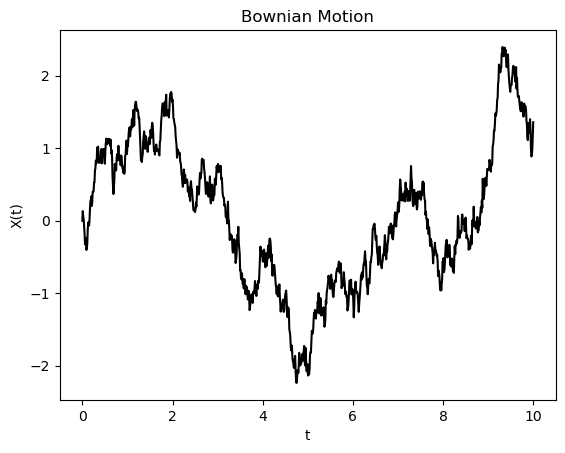

In [2]:
T = 10; N = 1000
t, X = Utils.BrownianMotion(T, N, seed=24)
Utils.Plot(t, X, 't', 'X(t)', 'Bownian Motion')

Since for a fixed $w$, $X(t, w)$ is a real-valued determined function $f$: $\Tau \rightarrow \mathbf{R}$, note the set of $f$ as $\mathbf{R}^{\mathbf{T}}$, whose Borel set noded as $\mathcal{B}(\mathbf{R}^{\mathbf{T}})$. So it is fair to say that a sample path defines a $\mathbf{R}^{\mathbf{T}}$-valued random variable. 

We need to distinguish the difference between independent processes and independent pathes. An important theorem says that: Any real-valued second order stochastic process $\{X(t): t\in \mathbf{T}\}$ with $\mu(t)$ and $C(s, t)$, then $\mu: \mathbf{T}\rightarrow \mathbf{R}$ and $C: \mathbf{T}\times \mathbf{T}\rightarrow \mathbf{R}$ is symmetric and non-negative definite. Conversely is also true: Any such $\mu, C$ is a mean and covariance of some stochastic process. So if the process is a Gaussian Process, then the process is determined by its mean and covariance function.

### Examples
#### Gaussian Process with cosine covariance
we take $C(s, t) = cos(s-t)$. We  can vertify that $C(s,t)$ is a symmetric and non-negative definite. Also we find that $X(t)=\xi_1cos(t) + \xi_2sin(t)$ is a Gaussian process with mean 0 and covariance $cos(s-t)$. We plot some sample paths.

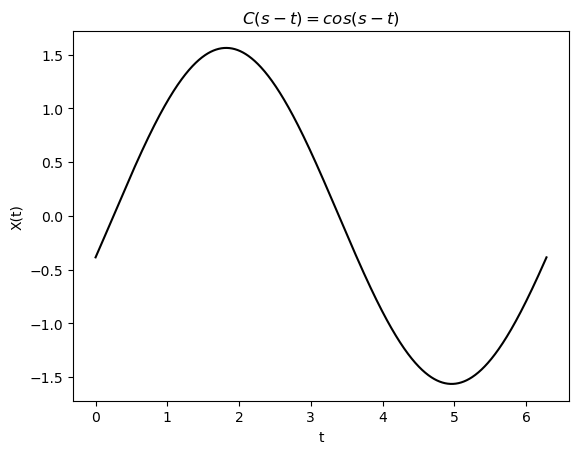

In [17]:
def Xt_cosine_covariance(T, N, seed=None):
    t = np.linspace(0, T, N + 1)
    np.random.seed(seed)
    xi = np.random.randn(2)
    X = np.cos(t) * xi[0] + np.sin(t) * xi[1]
    return t, X
T = 2*pi; N = 1000
t, X = Xt_cosine_covariance(T, N)
Utils.Plot(t, X, 't', 'X(t)', '$C(s-t) = cos(s-t)$')

#### Brownian Bridge
It is interesting to consider the values of Brownian Motion in $(0, T)$, having fixed value at specific points like $t=0$ and $t=T$. We call that **Brownian Bridge** $B(t)$. So we can write the dinite-dimentional distribution of $B(t)$ as: $$...$$
And for measurable function $\phi: \mathbf{R}^N\rightarrow \mathbf{R}$, we have $$...$$
then we have the mean and covariance function: $$...$$
We can vertify that Brownian Bridge $\{B(t): t\in [0, T]\}$ with condition $B(0)=B(T)=0$ is Gaussian with mean zero and covariance $C(s,t)=min\{s,t\}-st/T$. And $W(t) - tW(T)/T$ has the same distribution as $B(t)$.

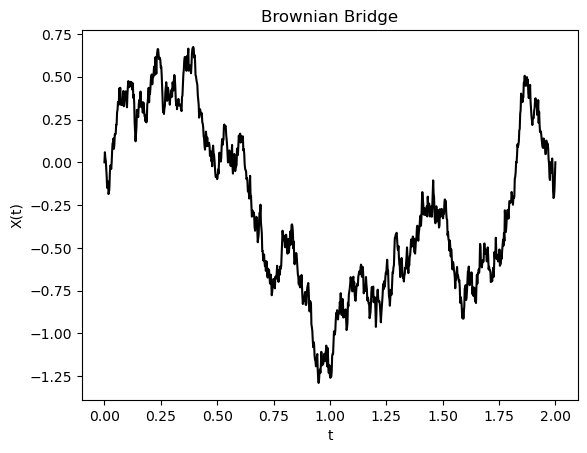

In [44]:
def BrownianBridge(T, N, seed=None):
    t, W = Utils.BrownianMotion(T, N, seed=seed)
    B = W - W[-1] * (t - t[0]) / (t[-1] - t[0])
    return t, B
t, B = BrownianBridge(2, 1000, 24)
Utils.Plot(t, B, 't', 'X(t)', 'Brownian Bridge')

#### Fractional Bownian Motion
The Brownina Motion have two good properties: 
1. self-similarity: $\tilde{W}(t) = \alpha W(t/\alpha)$ has the same distribution as $W(t)$
2. stationary increments: $W(t) - W(s)$ is the same distribution as $W(t+h) - W(s+h)$

We define the fractional Brownian Motion $B^H(t)$ where $H\in (0,1)$ is the Hurst param: a Gaussian process with mean zero and covariance function $\frac{1}{2}(|t|^{2H}+|s|^{2H}-|t-s|^{2H})$. 

It can be found that the increments of fBM is correlated. So the sample path will be shown later using KL expansion; But when $H=\frac{1}{2}$, the fBM is Brownian Motion, which is much easier to show.

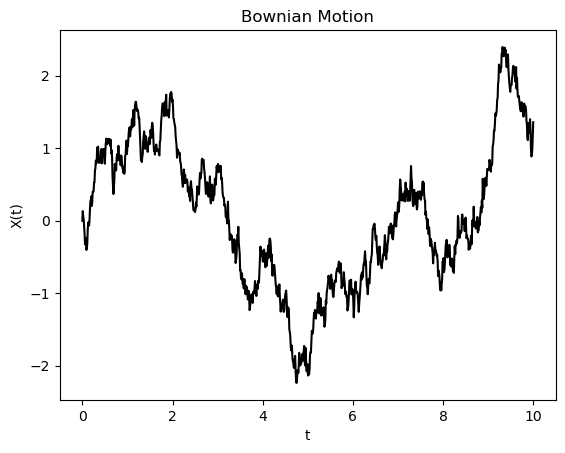

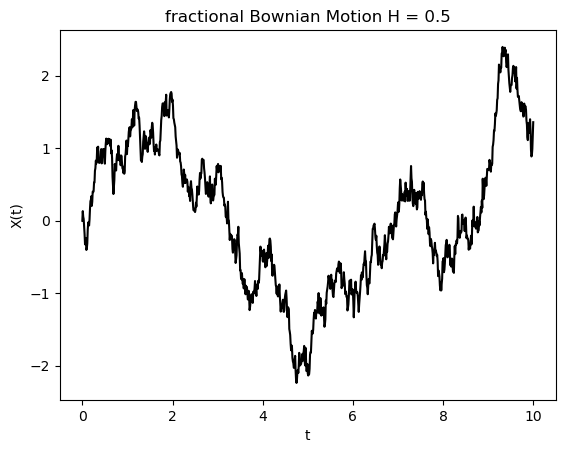

In [47]:
T = 10; N = 1000
t, X = Utils.BrownianMotion(T, N, seed=24)
Utils.Plot(t, X, 't', 'X(t)', 'Bownian Motion')
alpha = 0.3
_, X2 = Utils.BrownianMotion(T/alpha, N, seed=24)
Utils.Plot(t, sqrt(alpha) * X2, 't', 'X(t)', 'fractional Bownian Motion H = 0.5')

#### White noise and coloured noise
The white noise contains a homogeneous mix of all different basis functions. So for $\Tau=[0, T]$, we can find an orthogonal basis $\{\phi_i\}$ for $L^2(\Tau)$. Then consider $$\zeta(t)=\sum_{j=1}^{\infty} \xi_j \phi_j(t)$$ Then we find that the covariance function is $\delta(s-t)$(Dirac function). That means that the white noise is not well-defined in $L^2(\Omega)$. the truncated $\zeta_J(t)$ doesn't converge to functions in $L^2(\Tau)$ as $J\rightarrow \infty$. 

In contrast, the coloured noise is a stochastic process like $$X(t) = \sum_{j=1}^{\infty} \sqrt{v_j}\xi_j \phi_j(t)$$ 
We show that white noise doesn't converge as follows.


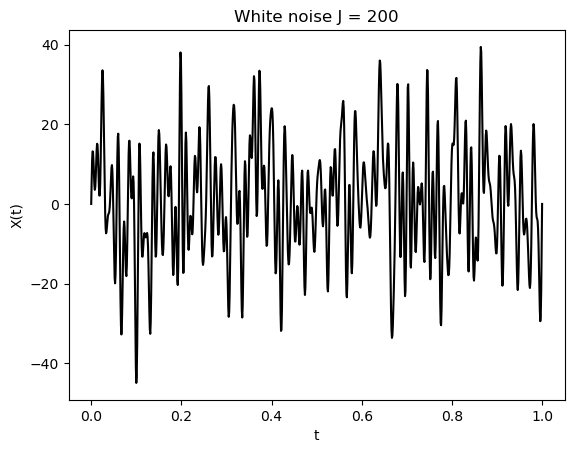

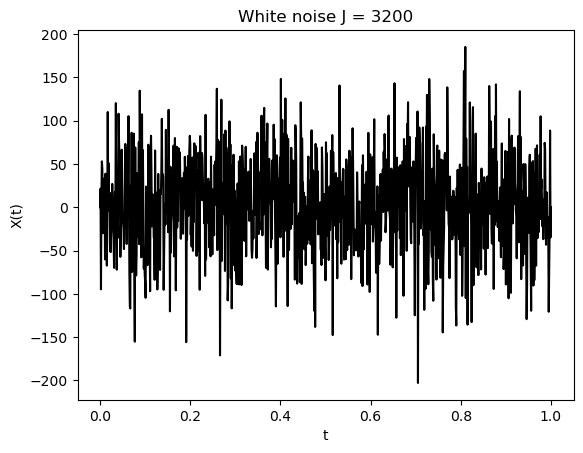

In [49]:
def white_noise(T, N, J, seed=None):
    np.random.seed(seed)
    t = np.linspace(0, T, N + 1)
    xi = np.random.randn(J)
    phi = np.zeros(N + 1)
    for j in range(1, J+1):
        phi = phi + sqrt(2) * np.sin(j * pi * t) * xi[j-1]
    return t, phi

T = 1; N = 1000
t, zeta = white_noise(T, N, 200, seed=24)
Utils.Plot(t, zeta, 't', 'X(t)', 'White noise J = 200')
t, zeta = white_noise(T, N, 3200, seed=24)
Utils.Plot(t, zeta, 't', 'X(t)', 'White noise J = 3200')

### The Karhunen-Loeve expansion
So usually the increments is not uncorrelated ideally, like the fBM, which we cannot simulate just as B.M. step by step. Let $X(t)$ be a real-valued **Gaussian Process** with mean $\mu$ and covariance function $C(s, t)$, define $$...$$
#### Discrete
So first and foremost, the covariance matrrix **C** is known to be symmetric and non-negative definite, then C can be decomposited by spectral decomposition as $C=U\Sigma U^T$, where $v_j$ is diagonal of $\Sigma$, $u_j$ is column vector of $U$. Let $V = U \Sigma ^{\frac{1}{2}}$, then X can be rewriten as 
$$X = \mu + \sum_{j=1}^N\sqrt{v_j}u_j \xi_j,\qquad \xi\ i.i.d\sim N(0, 1)$$

Using this, we can simulate the fBM then.

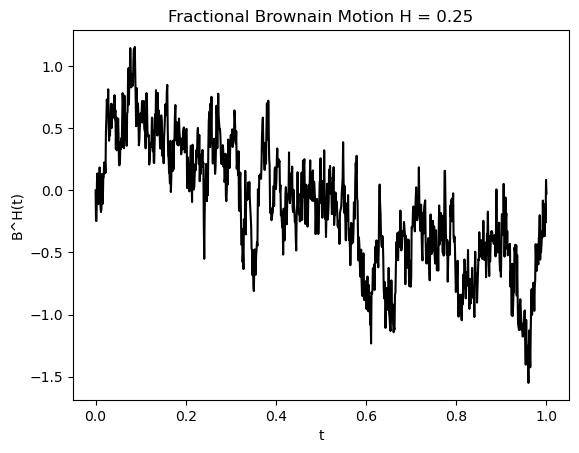

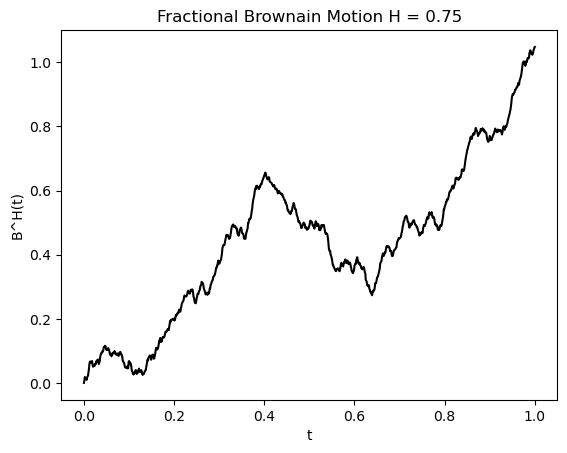

In [54]:
def fBM(T, N, H, seed = None):
    '''H is Hurst parameter of fBM'''
    t = np.linspace(0, T, N + 1)
    C = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(N + 1):
            ti = t[i]; tj = t[j]
            C[i, j] = 0.5 * (pow(ti, 2*H) + pow(tj, 2*H) - pow(abs(ti - tj), 2*H))
    S, U = np.linalg.eig(C)
    np.random.seed(seed)
    xi = np.random.randn(N + 1)
    X = np.dot(U, S**0.5 * xi)
    return t, X
T = 1; N = 1000; H = 1/4
t, BH = fBM(T, N, H)
Utils.Plot(t, BH, 't', 'B^H(t)', f'Fractional Brownain Motion H = {H}')
H = 3/4
t, BH = fBM(T, N, H)
Utils.Plot(t, BH, 't', 'B^H(t)', f'Fractional Brownain Motion H = {H}')

So, if the eigenvalue of C decays rapidly, then we can truncated the series, that is we can use $n<N$ r.v. to approcimate X. The truncated spectral decomposition actually provides a form of modal reduction.

#### Continuos
The generalization of spectral decomposition to stochastic process is KL expansion. We find that when the partition unmber increases, the covariance matrix begin larger, the cost of decomposition rises. It is much a discrete way. So we are interested in writing $X(t, w)-\mu(t)$ continuously as a series in an orthonormal way. Usually we call the former discrete KL expansion.

That is $$ X(t, w)-\mu(t)=\sum_{j=1}^\infty \gamma _j(w)\phi_j(x)$$， where the coefficients $\gamma_j$ are random variables given by $$...$$ We can define the integral operator $\mathcal{C}$: $$(\mathcal{C}f)(t)=\int_\mathbf{T} C(s, t)f(s)ds$$. The basis function $\phi_j$ are chosen to be eigenfunctions of $\mathcal{C}$. 

**[Theorem]**

Then the covariance function $$C(s, t) = \sum_{j=1}^J v_j \phi_j(s)\phi_j(t)$$

##### Example

